# Pre-train SynthText

In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from text_data import datasets, target_transforms, transforms, augmentations
from text_data.utils import batch_ind_fn_droptexts

from textboxespp.models.textboxespp import TextBoxesPP
from ssd.train import *
from textboxespp.train.loss import TextBoxLoss, ConfidenceLoss

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
import torch

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
augmentation = augmentations.RandomSampled()
#augmentation = None

transform = transforms.Compose(
    [transforms.Resize((384, 384)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Corners2Centroids(),
     #target_transforms.ToQuadrilateral(),
     target_transforms.OneHot(class_nums=datasets.SynthText_class_nums, add_background=True),
     target_transforms.ToTensor()]
)

#train_dataset = datasets.COCO2014Text_Dataset(ignore=target_transforms.Ignore(illegible=True), transform=transform, target_transform=target_transform, augmentation=None)
train_dataset = datasets.SynthTextDataset(ignore=None, transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=batch_ind_fn_droptexts,
                          num_workers=4,
                          pin_memory=True)

In [3]:
model = TextBoxesPP(input_shape=(384, 384, 3)).cuda()
model.load_vgg_weights()
print(model)

TextBoxesPP(
  (codec): TextBoxCodec(
    (encoder): TextBoxEncoder()
    (decoder): TextBoxDecoder()
  )
  (defaultBox): DBoxTextBoxOriginal()
  (predictor): TextBoxPredictor()
  (inferenceBox): InferenceBox()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dila

<IPython.core.display.Javascript object>


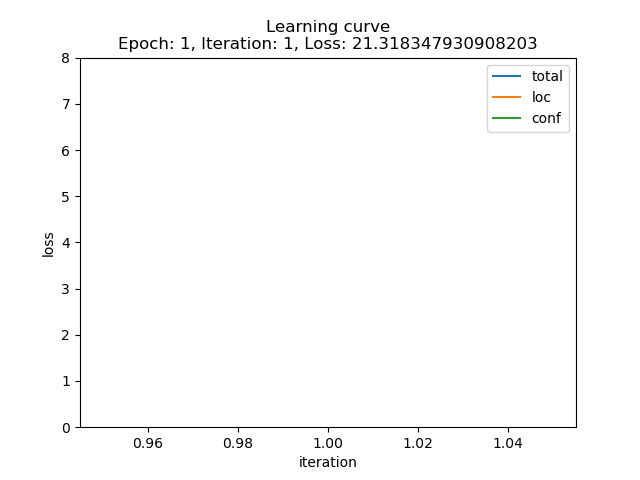

Training... Epoch: 1, Iter: 24,	 [768/858750	 (0%)]	Loss: 6.790271, Loc Loss: 17.235067, Conf Loss: 3.343257	Iter time: 0.34477

KeyboardInterrupt: 

In [4]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
# iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(10, 20, 30), gamma=0.1, verbose=True)
# iter_sheduler = SSDIterStepLR(optimizer, step_size=60000, gamma=0.1, verbose=True)

save_manager = SaveManager(modelname='pretrained-synthtext', interval=5000, max_checkpoints=15, savedir='../weights/')
log_manager = LogManager(interval=100, save_manager=save_manager, loss_interval=100, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=3)), optimizer=optimizer, scheduler=None,
                      log_manager=log_manager)

trainer.train(60000, train_loader)  # , evaluator=VOC2007Evaluator(val_dataset, iteration_interval=10))
